# Libraries and functions

In [6]:

##############################################################################################################################################
##############################                                                                                   #############################
##############################                                        European Climate Assessment  &             #############################
##############################                                                 Eurostat                          #############################
##############################                                             Updated 14/11/22                      #############################
##############################################################################################################################################

###  librairies declaration
import warnings
import time
import pandas                             as pd
#import duckdb                             as db
import missingno                          as missin

import numpy                              as np
lasource_de_donnees="Sources : European Climate Assessment & Dataset (ECAD) & Eurostat urb-cpop - Updated 14/11/22"
import plotly.express                     as px
import plotly.graph_objects               as go

from math import *
import scipy.stats                        as st

# Missing value
import missingno                          as msno # msno.bar(le_df) ou matrix(le_df) ou heatmap(le_df)

from scipy.stats                          import chi2_contingency
from sklearn.cluster                      import KMeans
import seaborn                            as sns; sns.set()

import matplotlib.pyplot                  as plt
#import seaborn            as sns

import statsmodels.api                    as sm
import statsmodels.formula.api            as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn                              import preprocessing,cluster,decomposition,metrics  # normalisation

# Function biplot :
import matplotlib                         as mpl
import matplotlib.cm                      as cm
from scipy.spatial                        import ConvexHull

# Normaliser les donnees :
from sklearn.preprocessing                import StandardScaler

warnings.filterwarnings('ignore')

# Set max rows displayed for readability
#pd.set_option("display.max_rows", 23)
# Configure display options
pd.set_option("display.max_columns", None)

def calculer_plage_max(var_x,var_y,df):
    '''
    Allows you to establish the maximum range without interruption or there is a lot of data (temperatures, number of cities, etc.)
    '''
    x=df[var_x];y=df[var_y]-df[var_y].quantile(0.50)
    # Identifier les points où la courbe traverse l'axe des abscisses
    points_intersection = np.where(y >= 0)[0]
    # Initialise debut /fin de segement
    debut_segment = 0; fin_segment = 0;sav_plage_max=0; sav_debut_segment=0;sav_fin_segement=0; plage_max=0;iteration=0

    # il faut trouver le plus long segement
    for i in range(len(points_intersection) - 1):
        #print("1ere i ",i)
        if debut_segment ==0 & iteration== 0:
            debut_segment = points_intersection[i]
            iteration=points_intersection[i]+1            
        else:
            if iteration==points_intersection[i]:
                plage_max = points_intersection[i]-debut_segment
                fin_segment=points_intersection[i]
                iteration=points_intersection[i]+1 
            else:
                # save plage max 
                if plage_max>sav_plage_max:
                    sav_plage_max=plage_max
                    sav_debut_segment=debut_segment
                    sav_fin_segment=fin_segment
                iteration=points_intersection[i]+1  
                debut_segment=points_intersection[i]
                plage_max=0
                
    return var_y,df.iloc[sav_debut_segment,0],df.iloc[sav_fin_segment,0]


strdirectory="../Analyse Temperature Europe/"

## Open Files de fichier

In [7]:
# Fichier à ouvrir
fichier=pd.read_csv(strdirectory+'Extraction_etape_1_data_temps_hab.csv')

fichier['DATE_str_YEAR']=fichier['DATE_str_YEAR'].astype(str)
fichier['DATE_str_MONTH']=fichier['DATE_str_MONTH'].astype(str)
fichier['DATE_str_DAY']=fichier['DATE_str_DAY'].astype(str)

Missing Value ?

<Axes: >

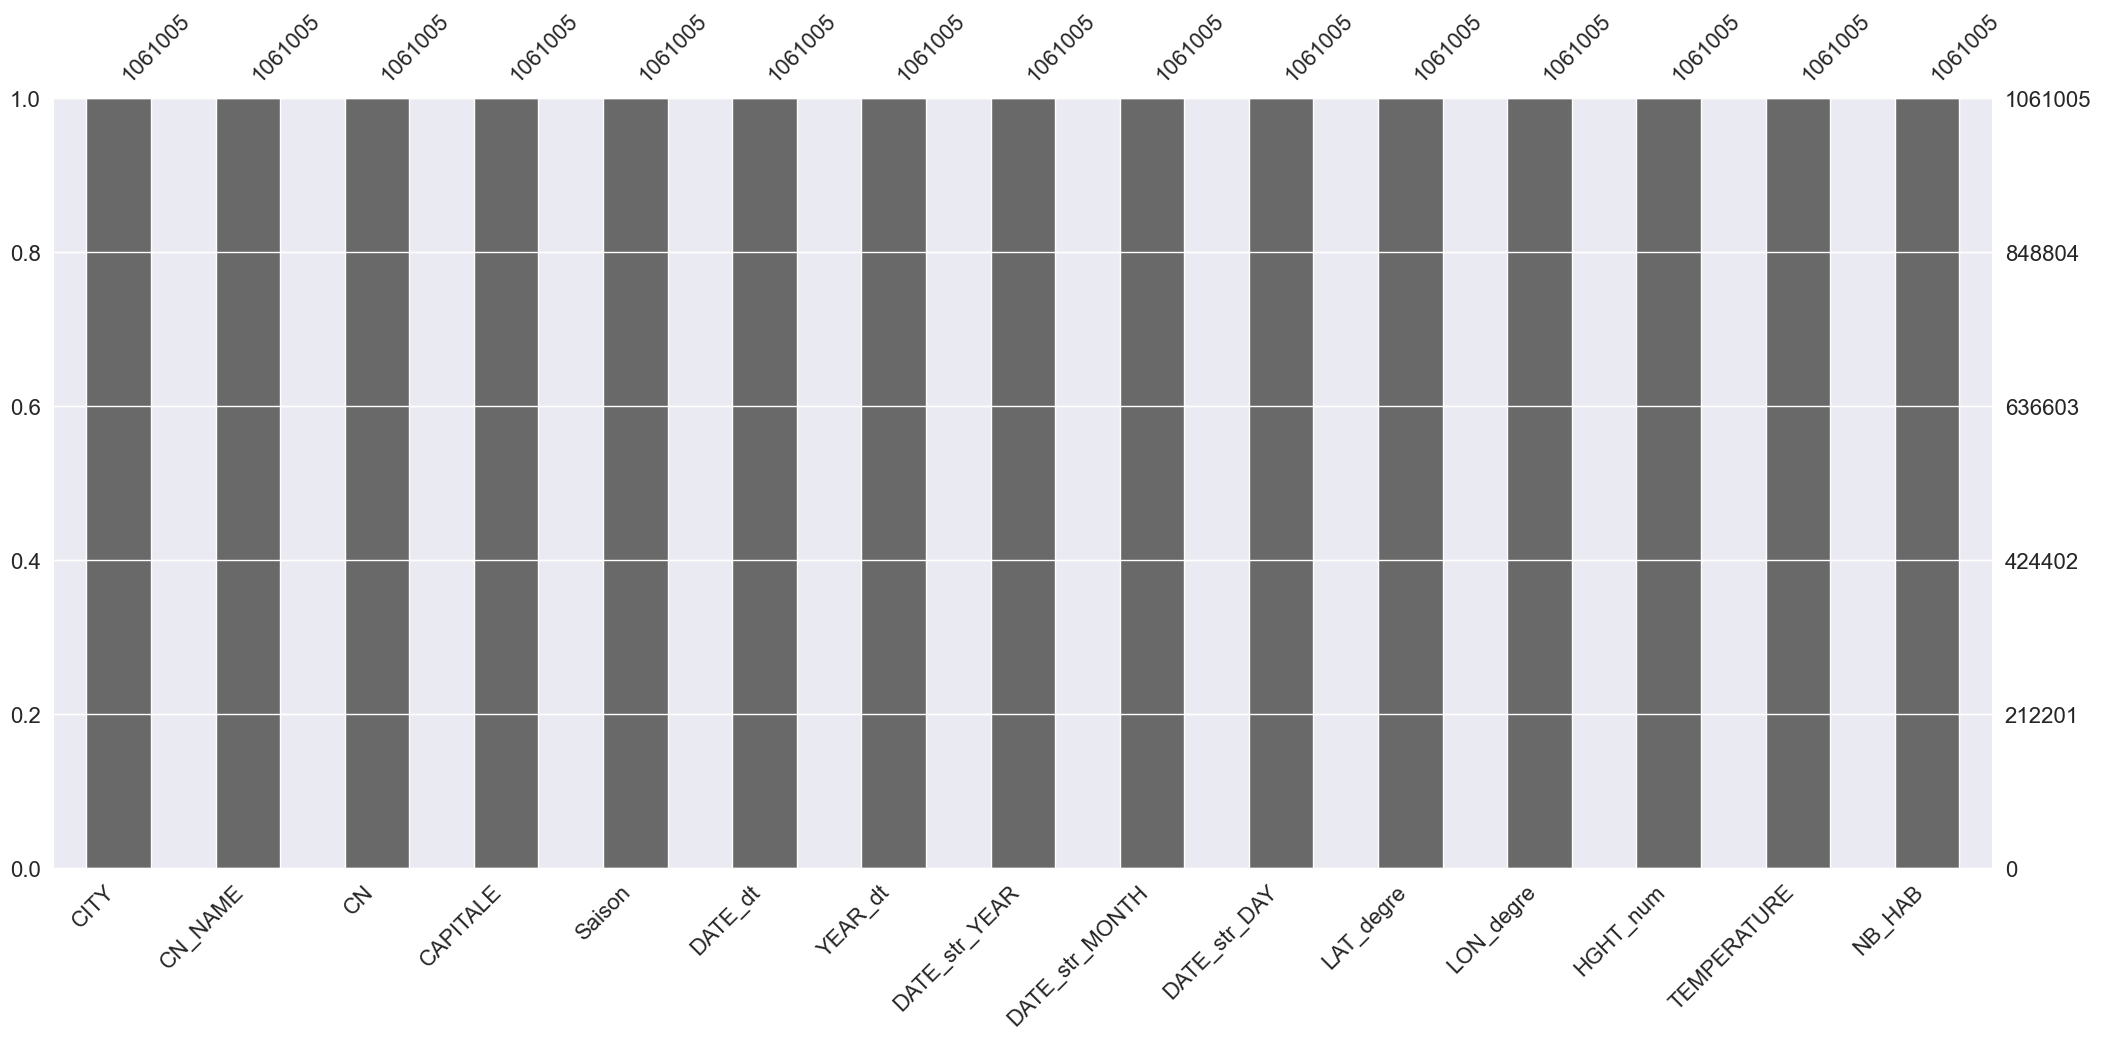

In [8]:
missin.bar(fichier)

Doublon ?

In [9]:
fichier[fichier.duplicated()]

,CITY,CN_NAME,CN,CAPITALE,Saison,DATE_dt,YEAR_dt,DATE_str_YEAR,DATE_str_MONTH,DATE_str_DAY,LAT_degre,LON_degre,HGHT_num,TEMPERATURE,NB_HAB


# Time range to define

## What are the most relevant years to analyze ?

For each year, I make statistics on the number of registrations, the number of municipalities, the number of countries


In [10]:
annee_info=fichier.groupby(['DATE_str_YEAR'],as_index=False).agg({'DATE_dt':'count','DATE_str_MONTH':'nunique','CITY':'nunique','CN':'nunique'})
annee_info.rename(columns={'DATE_str_YEAR':'Annee','DATE_dt':'nb_enreg','DATE_str_MONTH':'nb_Mois','CITY':'nb_City','CN':'nb_CN'},inplace=True)

annee_info['Annee_int']=annee_info['Annee'].astype(int)
print(calculer_plage_max('Annee_int','nb_enreg',annee_info))
print(calculer_plage_max('Annee_int','nb_City',annee_info))
print(calculer_plage_max('Annee_int','nb_CN',annee_info))
print(" ")
print("Il semble que l'intervalle [2008,2015] soit cohérent.")
#@seuil

('nb_enreg', '2008', '2015')
('nb_City', '2008', '2015')
('nb_CN', '2004', '2009')
 
Il semble que l'intervalle [2008,2015] soit cohérent.


nb_enreg n° 1


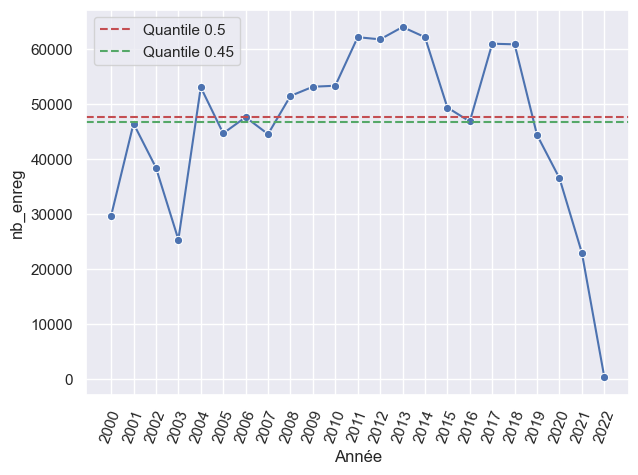

nb_City n° 2


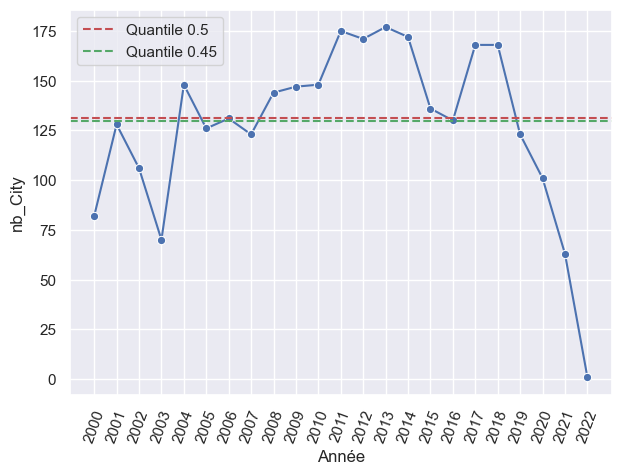

nb_CN n° 3


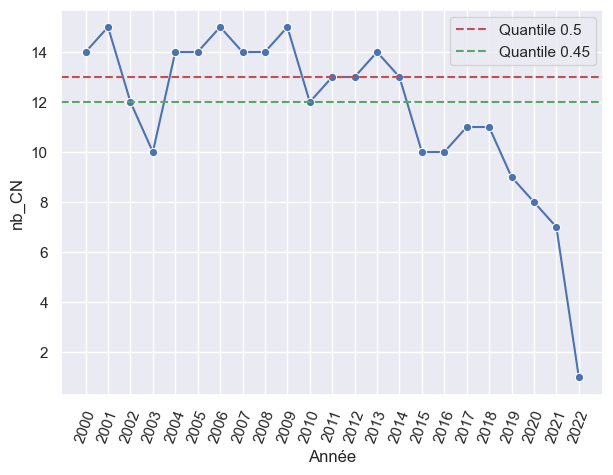

In [11]:


# Sélection des variables quantitatives
quant_vars = annee_info[['Annee','nb_enreg','nb_Mois','nb_City','nb_CN']]
enumere=0

for var in quant_vars:
  if var!='Annee' and var!='nb_Mois':
    plt.figure(figsize=(7,5))
    enumere=enumere+1
    print(var,"n°",enumere)
    ax=sns.lineplot(x='Annee',y=var,marker='o',data=annee_info)
    plt.xticks(rotation=70)
    # Ajoutez des étiquettes d'axe
    ax.set_xlabel('Année')
    #ax.set_ylabel(var)
    # Ajoutez une ligne horizontale à la position y=10 (remplacez par votre valeur)
    ax.axhline(y=annee_info[var].quantile(0.50), color='r', linestyle='--', label='Quantile 0.5')
    ax.axhline(y=annee_info[var].quantile(0.45), color='g', linestyle='--', label='Quantile 0.45')
    plt.legend()
    plt.show()

In [12]:
borne_inf=calculer_plage_max('Annee_int','nb_enreg',annee_info)[1]
borne_sup="2017"

print("Given the visual, we will take as a limit","inf :",borne_inf, "; sup : 2017")


Given the visual, we will take as a limit inf : 2008 ; sup : 2017


## Select timeline

In [13]:
# On merge les min et max
fichier_plage_min_max=pd.merge(fichier.query("DATE_str_YEAR >= @borne_inf & DATE_str_YEAR<= @borne_sup").groupby(['CITY','CN_NAME','CN','CAPITALE'],as_index=False).agg({'DATE_str_YEAR':'min'}),
                               fichier.query("DATE_str_YEAR >= @borne_inf & DATE_str_YEAR<= @borne_sup").groupby(['CITY','CN_NAME','CN','CAPITALE'],as_index=False).agg({'DATE_str_YEAR':'max'}),on=['CITY','CN_NAME','CN','CAPITALE'],how='inner')

fichier_plage_min_max.rename(columns={'DATE_str_YEAR_x':'Annee_min','DATE_str_YEAR_y':'Annee_max'},inplace=True)

fichier_plage_min_max_filtre=fichier_plage_min_max#

fichier_an_stat=fichier.groupby(['CITY','CN_NAME','CN','CAPITALE','DATE_str_YEAR'],as_index=False).agg({'DATE_dt':'count',
                                'Saison':'nunique','DATE_str_MONTH':'nunique'}).query("DATE_str_MONTH==12 & (DATE_str_YEAR >= @borne_inf & DATE_str_YEAR<= @borne_sup)")
fichier_an_stat.rename(columns={'DATE_dt':'nb_enreg_par_an','Saison':'nb_saison_par_an','DATE_str_MONTH':'nb_mois_enreg_par_an'},inplace=True)

fichier_plage_tempo_stat=fichier_an_stat.groupby(['CITY','CN_NAME','CN','CAPITALE'],as_index=False).agg({'DATE_str_YEAR':'nunique','nb_mois_enreg_par_an':'sum','nb_enreg_par_an':'sum'})
fichier_plage_tempo_stat.rename(columns={'DATE_str_YEAR':'nb_annee','nb_enreg_par_an':'nb_enreg','nb_mois_enreg_par_an':'nb_mois'},inplace=True)


fichier_plage_tempo_stat_cplt=pd.merge(fichier_plage_min_max_filtre,fichier_plage_tempo_stat,on=['CITY','CN_NAME','CN','CAPITALE'],how='inner')

# Creation du referentiel à partir duquel les villes vont être selectionnées
df_referentiel_fichier=fichier_plage_tempo_stat_cplt.query("Annee_min==@borne_inf & Annee_max==@borne_sup & nb_annee >=10 & nb_mois >=120") # & Annee_min=='20'
# Voici le fichier  sur lequel optimisation des données :
df_extract=pd.merge(df_referentiel_fichier.sort_values('CITY')['CITY'],fichier.query("DATE_str_YEAR >=@borne_inf & DATE_str_YEAR<=@borne_sup").sort_values('CITY'), on=['CITY'],how='inner')

In [14]:
#######################################                 ECRITURE                #################################

In [15]:
df_extract.to_csv(strdirectory+'Selection_etape_2_data_temps_hab.csv', index=False,encoding='utf-8')

In [16]:
#######################################                     FIN                 ################################